In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tflearn.data_utils as du
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D 
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img
import warnings
import matplotlib.image as mpimg
import os 
import cv2
import tensorflow as tf 
from PIL import Image 
from numpy import asarray
from tqdm import tqdm
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename
from tkinter import messagebox


Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#we need to convert the images to a matrix so we can build our test and train sets

DIRECTORY = r"C:\Users\rassa\Documents\Machine Learning A-Z  Udemy\Arabic Handwritten Characters Dataset"
train_data = []
test_data = []
trainPath = DIRECTORY + r"\Train Images 13440x32x32\train"
testPath  = DIRECTORY + r"\Test Images 3360x32x32\test"

def getImgId(imgName):
    return int(imgName.split('_')[1])

def makeData(data, directory, sortingCriteria):
    imgFileNameList = os.listdir(directory)     #get list of directories in path (ie. list of image names)
    imgFileNameList.sort(key = sortingCriteria) #sort list based on key
    
    for img in tqdm(imgFileNameList):  # iterate over the sorted list
                try:
                    img_array = cv2.imread(os.path.join(directory, img) ,cv2.IMREAD_GRAYSCALE)  # convert image to array
                    data.append([img_array])  # add this to our data
                except Exception as e:  # just in case there is a mistake.
                    pass

makeData(train_data, trainPath, getImgId)
makeData(test_data, testPath, getImgId)

# convert to ndarray and reshape
train_data = np.asarray(train_data).reshape([-1, 32, 32, 1])
test_data = np.asarray(test_data).reshape([-1, 32, 32, 1])

100%|████████████████████████████████████████████████████████████████████████████| 3360/3360 [00:01<00:00, 2002.91it/s]


In [3]:
#Load the labels
#header = 0 because
#this creates a pandas dataframe (basically a table)
train_label = pd.read_csv(DIRECTORY + '/csvTrainLabel 13440x1.csv', header = None)
test_label = pd.read_csv(DIRECTORY +  '/csvTestLabel 3360x1.csv', header = None)

In [4]:
#train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1
#test_data = test_data.iloc[:,:].values.astype('float32') we don't need these anymore
test_label = test_label.iloc[:,:].values.astype('int32')-1


In [5]:
train_label = du.to_categorical(train_label,28)

In [6]:
train_data = train_data/255
test_data = test_data/255

In [7]:
#train_data, mean1 = du.featurewise_zero_center(train_data)
#test_data, mean2 = du.featurewise_zero_center(test_data)

In [8]:

recognizer = Sequential()
#for any kind of deep learning we use the sequential model in keras then 
#add layers to it
recognizer.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
#the first 2 dimensional convolusion layer will have 32 filters. filters or kernels are 
#what we use to extract features. in this case they are of size 3x3 (kernel size)
#in the first layer it is necessary to specify the shape so for our case its a
#32x32 pixel image and since it's black and white then it has only one dimension or channel
#if it was colored then we would have (32,32,3)
#activation='relu' this is rectified linear unit. the output filters or convolved layers
#might contain some negative values so we apply the rectifier function (or other functions) to break linearity
recognizer.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(AveragePooling2D(pool_size=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
recognizer.add(Dropout(0.25))


recognizer.add(Flatten())
recognizer.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
recognizer.add(Dense(units = 256, activation = "relu"))
recognizer.add(Dropout(0.5))
recognizer.add(Dense(28, activation = "softmax"))

In [9]:
recognizer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0

In [10]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [11]:
recognizer.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [13]:
datagen.fit(train_data)

In [14]:
recognizer.fit_generator(datagen.flow(train_data,train_label, batch_size=100),
                             epochs = 30, verbose = 2, steps_per_epoch=train_data.shape[0] // 100)

C:\Users\rassa\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/30
134/134 - 31s - loss: 2.3736 - acc: 0.2806
Epoch 2/30
134/134 - 30s - loss: 1.2867 - acc: 0.5784
Epoch 3/30
134/134 - 30s - loss: 0.9239 - acc: 0.6936
Epoch 4/30
134/134 - 31s - loss: 0.7148 - acc: 0.7678
Epoch 5/30
134/134 - 30s - loss: 0.5792 - acc: 0.8052
Epoch 6/30
134/134 - 30s - loss: 0.5039 - acc: 0.8356
Epoch 7/30
134/134 - 30s - loss: 0.4425 - acc: 0.8576
Epoch 8/30
134/134 - 31s - loss: 0.4107 - acc: 0.8682
Epoch 9/30
134/134 - 30s - loss: 0.3730 - acc: 0.8802
Epoch 10/30
134/134 - 31s - loss: 0.3434 - acc: 0.8912
Epoch 11/30
134/134 - 32s - loss: 0.3095 - acc: 0.9013
Epoch 12/30
134/134 - 35s - loss: 0.2937 - acc: 0.9078
Epoch 13/30
134/134 - 33s - loss: 0.2786 - acc: 0.9113
Epoch 14/30
134/134 - 32s - loss: 0.2635 - acc: 0.9164
Epoch 15/30
134/134 - 32s - loss: 0.2599 - acc: 0.9196
Epoch 16/30
134/134 - 32s - loss: 0.2350 - acc: 0.9232
Epoch 17/30
134/134 - 32s - loss: 0.2386 - acc: 0.9250
Epoch 18/30
134/134 - 31s - loss: 0.2199 - acc: 0.9298
Epoch 19/30
134/134

In [15]:
predictions = recognizer.predict(test_data)
predictions = np.argmax(predictions,axis = 1)

C:\Users\rassa\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [16]:
cm = confusion_matrix(test_label, predictions)

In [17]:
# accuracy: (tp + tn) / (p + n)
accuracy = sum(cm[i][i] for i in range(28)) / test_label.shape[0]
print("accuracy = " + str(accuracy))

accuracy = 0.9630952380952381


In [18]:
print(cm)

[[120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0 119   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 118   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   6 113   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0 119   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2 118   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2 118   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 118   0   2   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   6 107   1   2   0   0   0   0   

In [19]:
def outputMsg(l):
    switcher = {
        0: "zero",
        1 : "alif",
        2 : "ba2",
        3: "ta2",
        4: "tha2",
        5: "jha2",
        6: "7a2",
        7: "5a2",
        8: "da2",
        9: "thal",
        10: "ra2",
        11: "za2",
        12: "seen", 
        13: "sha2",
        14: "saad",
        15: "thaad",
        16: "ttaa2",
        17: "ththa",
        18: "3ayn",
        19: "ghayn",
        20: "fa2",
        21: "9a2",
        22: "ka2",
        23: "lam",
        24: "meem",
        25: "noon",
        26: "haa2",
        27: "waw",
        28: "ya2"
    }
    print("Your letter is " + switcher.get(l, "Invalid label"))
    #messagebox.showinfo("Prediction", "Your letter is " + switcher.get(l, "Invalid label"))
    


* Enter the alpha value [1.0-3.0]: 1.25
* Enter the beta value [0-100]: 25
174.0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


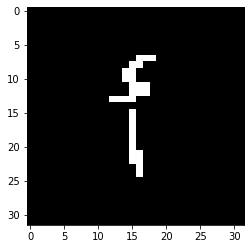

In [25]:

# Read image given by user


Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
image = cv2.imread(filename)#r"C:\Users\rassa\Desktop\Desktop2.0\CNN\9alb-Ba2-0.png") #(cv.samples.findFile(args.input))

contrast_img = np.zeros(image.shape, image.dtype)

alpha = 1.0 # Simple contrast control
beta = 0    # Simple brightness control

# Initialize values
try:
    alpha = float(input('* Enter the alpha value [1.0-3.0]: '))
    beta = int(input('* Enter the beta value [0-100]: '))
except ValueError:
    print('Error, not a number')
    
# Do the operation new_image(i,j) = alpha*image(i,j) + beta
# Instead of these 'for' loops we could have used simply:
# new_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
# but we wanted to show you how to access the pixels :)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            # the clip makes sure that the new values of the pixel are between 0 and 255
            contrast_img[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
        
#removethe three dimensions and turn image to gray scale
im_gray = cv2.cvtColor(contrast_img, cv2.COLOR_BGR2GRAY)
#binarize the image using Otsu method to get the threshold, binarize to black and white(ie. 255)
th, im_gray_th_otsu = cv2.threshold(im_gray, 128, 255, cv2.THRESH_OTSU)
#resizing...
resized = cv2.resize(im_gray_th_otsu, (32,32), interpolation = cv2.INTER_AREA)

#print the threshold because I'm curious
print(th)

final_img = np.zeros(resized.shape, resized.dtype)
for y in range(resized.shape[0]):
    for x in range(resized.shape[1]):
        if resized[y,x] < 125:     
            final_img[y,x] = 255
        else :
            final_img[y,x] = 0

#Show the images so we can compare them (use the cv2.imshow if you want to ee them all at once)
#cv2.imshow('New Image', im_gray_th_otsu)
#cv2.imshow('Original Image', image)
#cv2.imshow('Contrast image', contrast_img)
#cv2.imshow('resized Image', resized)
#cv2.imshow('final Image', final_img)
plt.imshow(image)
plt.imshow(contrast_img)
plt.imshow(im_gray_th_otsu, cmap='gray', vmin=0, vmax=255)
plt.imshow(resized, cmap='gray', vmin=0, vmax=255)
plt.imshow(final_img, cmap='gray', vmin=0, vmax=255)


final_img = np.asarray(final_img).reshape([-1, 32, 32, 1])
#final_img.reshape([1,32,32,1])
#final_img = np.expand_dims(final_img, -1)

predictions_single = recognizer.predict(final_img)
print(predictions_single)

#let's get our label
label = 0
for i in range(28):
    if predictions_single[0][i] == 1:
        label = i+1
        break


In [26]:
print(label)
outputMsg(label)

1
Your letter is alif


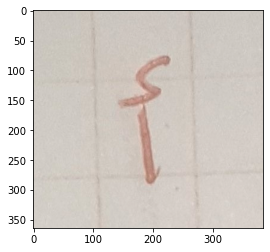

In [27]:
plt.imshow(contrast_img)


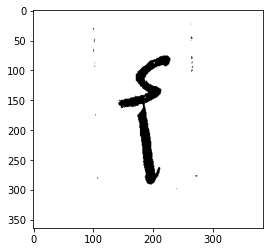

In [28]:
plt.imshow(im_gray_th_otsu, cmap='gray', vmin=0, vmax=255)


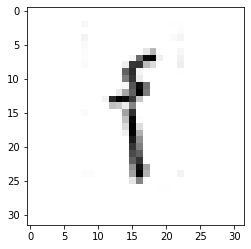

In [29]:
plt.imshow(resized, cmap='gray', vmin=0, vmax=255)


In [30]:
layer_names = [layer.name for layer in recognizer.layers]
layer_names

['conv2d',
 'conv2d_1',
 'average_pooling2d',
 'dropout',
 'conv2d_2',
 'conv2d_3',
 'max_pooling2d',
 'dropout_1',
 'flatten',
 'dense',
 'dense_1',
 'dropout_2',
 'dense_2']

In [31]:
recognizer.layers

In [34]:
layer_outputs = [layer.output for layer in recognizer.layers]
layer_outputs

[<tf.Tensor 'conv2d/Relu:0' shape=(?, 32, 32, 32) dtype=float32>,
 <tf.Tensor 'conv2d_1/Relu:0' shape=(?, 32, 32, 32) dtype=float32>,
 <tf.Tensor 'average_pooling2d/AvgPool:0' shape=(?, 16, 16, 32) dtype=float32>,
 <tf.Tensor 'dropout/cond/Merge:0' shape=(?, 16, 16, 32) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 16, 16, 64) dtype=float32>,
 <tf.Tensor 'conv2d_3/Relu:0' shape=(?, 16, 16, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 15, 15, 64) dtype=float32>,
 <tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 15, 15, 64) dtype=float32>,
 <tf.Tensor 'flatten/Reshape:0' shape=(?, 14400) dtype=float32>,
 <tf.Tensor 'dense/Relu:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dense_1/Relu:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dropout_2/cond/Merge:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dense_2/Softmax:0' shape=(?, 28) dtype=float32>]

In [38]:
feature_map_model = tf.keras.models.Model(inputs=recognizer.input, outputs=layer_outputs)


In [39]:
recognizer.input

<tf.Tensor 'conv2d_input:0' shape=(?, 32, 32, 1) dtype=float32>

In [40]:
feature_maps = feature_map_model.predict(final_img)


In [42]:
feature_maps[8].shape

(1, 14400)

In [43]:
print(feature_maps[8])

[[0.0024024 0.        0.        ... 0.        0.        0.       ]]


Let's see if it cares about image size

In [54]:
final_img.shape

(1, 32, 32, 1)

In [55]:
im_gray_th_otsu.shape

(364, 385)

In [57]:
type(im_gray_th_otsu)

numpy.ndarray

In [58]:
sizeTestingimg = np.asarray(im_gray_th_otsu).reshape([-1, 364, 385, 1])

In [59]:
feature_maps = feature_map_model.predict(sizeTestingimg)

ValueError: Error when checking input: expected conv2d_input to have shape (32, 32, 1) but got array with shape (364, 385, 1)

Yes it does... so we have to change the shapes of each segment to fit this shape...

In [63]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

In [46]:
testingmodel = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 108s 1us/step


In [47]:
testingmodel.layers

In [78]:
img=image.load_img(r"D:\School\MedTech\Sophomore Pre-Eng\ISS296\CNN\images\2alif.jpg",target_size=(224,224))
x = img_to_array(img)
x=np.expand_dims(x,axis=0)
x=preprocess_input(x)
testingmodeloutput = testingmodel.predict(x).flatten()

C:\Users\rassa\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [79]:
testingmodeloutput.shape

(51200,)

In [80]:
print(testingmodeloutput)

[0.        0.        0.        ... 0.3115046 1.2965667 0.       ]


## Lets try k clustering with the current dataset of characters first

In [96]:
#trainPath = DIRECTORY + r"\Train Images 13440x32x32\train"
#testPath  = DIRECTORY + r"\Test Images 3360x32x32\test"



def image_feature(directory, sortingCriteria):
    model = tf.keras.models.Model(inputs=recognizer.input, outputs=layer_outputs)
    features = [];
    img_name = [];
    
    imgFileNameList = os.listdir(directory)     #get list of directories in path (ie. list of image names)
    imgFileNameList.sort(key = sortingCriteria) #sort list based on key
    
    for img in tqdm(imgFileNameList):  # iterate over the sorted list
        #try:
            #img_array = cv2.imread(os.path.join(directory, img) ,cv2.IMREAD_GRAYSCALE)  # convert image to array
            #data.append([img_array])  # add this to our data
        #except Exception as e:  # just in case there is a mistake.
            #pass
            
    #for i in tqdm(direc):
        #fname='cluster'+'/'+i
        img_array = cv2.imread(os.path.join(directory, img) ,cv2.IMREAD_GRAYSCALE)   #img=image.load_img(fname,target_size=(224,224))
        #x = img_to_array(img)
        #x=np.expand_dims(x,axis=0)
        #x=preprocess_input(x)
        img_array=img_array.reshape([-1, 32, 32, 1])
        LoFeatureMaps = model.predict(img_array)   #feat=model.predict(x)
        #feat=feat.flatten()
        resizedFlattenedFeatureMap = LoFeatureMaps[8].reshape([LoFeatureMaps[8].shape[1]])
        features.append(resizedFlattenedFeatureMap) #features.append(feat)
        
        img_name.append(img)
    return features,img_name


LoTestImgFeatures,LoTestImgNames = image_feature(testPath, getImgId)


  0%|                                                                                         | 0/3360 [00:00<?, ?it/s]C:\Users\rassa\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|█████████████████████████████████████████████████████████████████████████████| 3360/3360 [00:17<00:00, 194.40it/s]


In [97]:
#Creating Clusters
k = 28
clusters = KMeans(k, random_state = 40)
clusters.fit(LoTestImgFeatures)

KMeans(n_clusters=28, random_state=40)

In [98]:
print(LoTestImgNames)

['id_1_label_1.png', 'id_2_label_1.png', 'id_3_label_2.png', 'id_4_label_2.png', 'id_5_label_3.png', 'id_6_label_3.png', 'id_7_label_4.png', 'id_8_label_4.png', 'id_9_label_5.png', 'id_10_label_5.png', 'id_11_label_6.png', 'id_12_label_6.png', 'id_13_label_7.png', 'id_14_label_7.png', 'id_15_label_8.png', 'id_16_label_8.png', 'id_17_label_9.png', 'id_18_label_9.png', 'id_19_label_10.png', 'id_20_label_10.png', 'id_21_label_11.png', 'id_22_label_11.png', 'id_23_label_12.png', 'id_24_label_12.png', 'id_25_label_13.png', 'id_26_label_13.png', 'id_27_label_14.png', 'id_28_label_14.png', 'id_29_label_15.png', 'id_30_label_15.png', 'id_31_label_16.png', 'id_32_label_16.png', 'id_33_label_17.png', 'id_34_label_17.png', 'id_35_label_18.png', 'id_36_label_18.png', 'id_37_label_19.png', 'id_38_label_19.png', 'id_39_label_20.png', 'id_40_label_20.png', 'id_41_label_21.png', 'id_42_label_21.png', 'id_43_label_22.png', 'id_44_label_22.png', 'id_45_label_23.png', 'id_46_label_23.png', 'id_47_label_2

In [99]:
LoTrueTestImgLabels = []
for imgName in LoTestImgNames:
    LoTrueTestImgLabels.append(imgName.split('_')[3].split('.')[0])

In [104]:
LoTrueTestImgLabels[i]

'1'

In [100]:
image_cluster = pd.DataFrame(LoTestImgNames,columns=['image name'])
image_cluster["clusterid"] = clusters.labels_
image_cluster["true label"] = LoTrueTestImgLabels # 0 denotes cat and 1 denotes dog

In [101]:
print(image_cluster)

                image name  clusterid true label
0         id_1_label_1.png          7          1
1         id_2_label_1.png         24          1
2         id_3_label_2.png          4          2
3         id_4_label_2.png          4          2
4         id_5_label_3.png         21          3
...                    ...        ...        ...
3355  id_3356_label_26.png          1         26
3356  id_3357_label_27.png         17         27
3357  id_3358_label_27.png         11         27
3358  id_3359_label_28.png          9         28
3359  id_3360_label_28.png         17         28

[3360 rows x 3 columns]


In [115]:
LoClusterIdsForLabel=[]
for label in range(1,28):
    clusterIdsFor_label = []
    for i in range(len(LoTrueTestImgLabels)):
        if int(LoTrueTestImgLabels[i]) == label:
            clusterIdsFor_label.append(clusters.labels_[i])
    LoClusterIdsForLabel.append(clusterIdsFor_label)

print(LoClusterIdsForLabel[0])

[7, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2, 2, 24, 24, 24, 24, 7, 24, 24, 7, 24, 24, 7, 24, 2, 24, 7, 24, 24, 7, 24, 24, 24, 24, 24, 24, 2, 7, 24, 24, 24, 24, 24, 24, 24, 24, 7, 7, 24, 24, 7, 24, 3, 24, 24, 24, 24, 24, 24, 3, 24, 24, 10, 24, 24, 7, 7, 24, 24, 24, 7, 24, 24, 24, 7, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 7, 24, 24, 7, 24, 7, 7, 2, 2, 24, 7, 24, 24, 24, 7, 24, 24, 24, 7, 24, 24, 24, 24, 24, 24, 7, 24, 24, 24, 24, 24, 24, 24, 2, 2]


In [109]:
max(set(clusterIdsFor_Alif), key=clusterIdsFor_Alif.count)

24

In [110]:
clusterIdsFor_Alif.count(24)

87

In [111]:
import collections


In [112]:
ctr = collections.Counter(clusterIdsFor_Alif)


Counter({7: 22, 24: 87, 2: 8, 3: 2, 10: 1})

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil
from character_segmentation import segment
from segmentation import line_horizontal_projection, word_vertical_projection

In [ ]:
recognizer.layers

In [ ]:
layer_outputs = [layer.output for layer in recognizer.layers]
layer_outputs

In [ ]:
feature_map_model = tf.keras.models.Model(inputs=recognizer.input, outputs=layer_outputs)


In [ ]:
recognizer.input

In [ ]:
feature_maps = feature_map_model.predict(final_img)


In [ ]:
feature_maps[8].shape

In [ ]:
print(feature_maps[8])

Let's see if it cares about image size

In [ ]:
final_img.shape

In [ ]:
im_gray_th_otsu.shape

In [ ]:
type(im_gray_th_otsu)

In [ ]:
sizeTestingimg = np.asarray(im_gray_th_otsu).reshape([-1, 364, 385, 1])

In [ ]:
feature_maps = feature_map_model.predict(sizeTestingimg)

Yes it does... so we have to change the shapes of each segment to fit this shape...

In [ ]:
testingmodel = InceptionV3(weights='imagenet', include_top=False)

In [ ]:
testingmodel.layers

In [ ]:
img=image.load_img(r"D:\School\MedTech\Sophomore Pre-Eng\ISS296\CNN\images\2alif.jpg",target_size=(224,224))
x = img_to_array(img)
x=np.expand_dims(x,axis=0)
x=preprocess_input(x)
testingmodeloutput = testingmodel.predict(x).flatten()

In [ ]:
testingmodeloutput.shape

In [ ]:
print(testingmodeloutput)